# About

Same as `RF_glacier.ipynb` but uses GradientBoosting algorithm instead

# Install dependencies

In [1]:
import sys
!{sys.executable} -m pip install pillow matplotlib scikit-image scikit-learn

You should consider upgrading via the '/Users/maxwellbergstrom/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


# Load libraries & define paths

In [2]:
import numpy as np
from skimage.io import imsave, imread
from skimage.segmentation import slic
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, auc, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import cv2 as cv # need to execute "pip install opencv-python" in the terminal to install module
import numpy as np
import os
import rasterio
from skimage import exposure, filters
from skimage.morphology import square
from skimage.color import rgb2gray
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import pickle
import seaborn as sns

In [3]:
# this is the path to the images from your current folder. To adapt
INPUT_DIR = "data/"

# 1. Create train/val/test sets
Use same data as that generated for `RF_glacier.ipynb`

### Split dataset into train/validation/test

Create list of features for each year, with label\
Features are :

SPECTRAL
- BO2_norm (B)
- B03_norm (G)
- B04_norm (R)
- NDWI
- NDSI
- SWIR ( 2 bands: B12, B8A)

MORPHOLOGICAL
- Sobel
- Sobel_v
- sobel_h
- autolevel
- entropy
- gabor
- meijering
- hessian

In [42]:
# Defining which images will belong to the train, test, and validation sets
train_dates = ['2018_0407', '2018_2907', '2019_0308', '2019_2210', '2020_0609', '2020_2110'] 
#validation_validation = [..]
test_dates = ['2017_0808', '2021_2208']


# List of features to use --> TO ADAPT: add SWIR
feature_list = ['B02_norm.npy', 'B03_norm.npy', 'B04_norm.npy', 'B12_norm.npy', 'B8A_norm.npy', 'NDWI.npy', 'NDSI.npy', 
                'sobel.npy', 'sobel_v.npy', 'sobel_h.npy', 'autolevel.npy' , 'entropy.npy',
                'gabor.npy', 'meijering.npy', 'hessian.npy']

col_names = ['B02', 'B03', 'B04', 'B12', 'B8A', 'NDWI', 'NDSI', 'sobel', 'sobel_v', 'sobel_h', 
                 'autolevel', 'entropy', 'gabor', 'meijering', 'hessian', 'label', 'date']

# Initialise feature and gt dataframes
df_train = pd.DataFrame(columns=col_names)

df_test = pd.DataFrame(columns=col_names)


for file in os.listdir(INPUT_DIR):
    if file.startswith("EO_Browser_images-"):
        CURRENT_PATH = INPUT_DIR + file
        
        # Extract year and date of current folder
        year = file.split("EO_Browser_images-", 1)[1].split("_", 1)[0]
        date = file.split("EO_Browser_images-", 1)[1]
        
        # Initialise a list of features for a certain year
        features_of_year = []
        
        # Train data
        if date in train_dates:
            print(date)
            for feature in feature_list:
                PATH_FEATURE = CURRENT_PATH = INPUT_DIR + file + "/" + feature
                
                # Open image and add it to the current year's list of features
                feat_img = np.load(PATH_FEATURE)
                # Flatten: 1 column per band. Shape nrows x ncols
                feat_img = feat_img.flatten() # puts all rows on the same line
                features_of_year.append(feat_img.T)

            # Find ground truth for that year and append to array
            GT_PATH = INPUT_DIR + 'gt/binary_gt_' + date + '.npy'
            gt_binary = np.load(GT_PATH)
            features_of_year.append(gt_binary.flatten().T)
            
            # Create array img height x width x (nbr features + 2). The +2 is because the date and label is added
            # One img has 895161 pixels
            nb_pixels = len(feat_img.flatten())
            date_column = np.repeat(date, nb_pixels)
            features_of_year.append(date_column)
            features_label_array = np.array(features_of_year).T
            print(features_label_array.shape)
            
            # Add to dataframe
            df_train = df_train.append(pd.DataFrame(features_label_array, columns=col_names))
            
            print("Added features and ground truth for that date")
        
        
        
        # Test data
        if date in test_dates:
            print(date)
            for feature in feature_list:
                PATH_FEATURE = CURRENT_PATH = INPUT_DIR + file + "/" + feature
                
               ## Open image and add it to the current year's list of features
                feat_img = np.load(PATH_FEATURE)
                # Flatten: 1 column per band. Shape nrows x ncols
                feat_img = feat_img.flatten() # puts all rows on the same line
                features_of_year.append(feat_img.T)

            # Find ground truth for that year and append to array
            GT_PATH = INPUT_DIR + 'gt/binary_gt_' + date + '.npy'
            gt_binary = np.load(GT_PATH)
            features_of_year.append(gt_binary.flatten().T)
            
            # Create array img height x width x 17
            # One img has 895161 pixels
            nb_pixels = len(feat_img.flatten())
            date_column = np.repeat(date, nb_pixels)
            features_of_year.append(date_column)
            features_label_array = np.array(features_of_year).T
            print(features_label_array.shape)
            
            # Add to dataframe
            df_test = df_test.append(pd.DataFrame(features_label_array, columns=col_names))
            
            print("Added features and ground truth for that date")

2020_2110
(895161, 17)
Added features and ground truth for that date
2018_0407
(895161, 17)
Added features and ground truth for that date
2019_0308
(895161, 17)
Added features and ground truth for that date
2017_0808
(895161, 17)
Added features and ground truth for that date
2020_0609
(895161, 17)
Added features and ground truth for that date
2021_2208
(895161, 17)
Added features and ground truth for that date
2019_2210
(895161, 17)
Added features and ground truth for that date
2018_2907
(895161, 17)
Added features and ground truth for that date


In [43]:
df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test

,B02,B03,B04,B12,B8A,NDWI,NDSI,sobel,sobel_v,sobel_h,autolevel,entropy,gabor,meijering,hessian,label,date
0,0.26141497,0.23551764,0.22510988,0.03784423,0.13890143,0.10999281,0.6774404,0.09260082979042836,0.02138267457485199,-0.12919987738132477,233,3.169925001442312,0.0047499985,0.3015191853046417,1.4230362467060331e-05,0.0,2017_0808
1,0.27852216,0.24601696,0.2254151,0.034526717,0.14768498,0.11331239,0.7090177,0.09144073152056888,-0.02691514790058136,-0.1264847368001938,255,3.584962500721156,-0.0008789359,0.30393823981285095,1.4447043213294819e-05,0.0,2017_0808
2,0.23942436,0.23061897,0.19211635,0.03220753,0.14768498,0.15756834,0.70826507,0.10579217444078956,-0.0965014174580574,-0.11433041840791702,205,3.773557262275185,-0.009345735,0.3087622821331024,1.4779848243051674e-05,0.0,2017_0808
3,0.21061225,0.21100904,0.16811134,0.030994179,0.13717276,0.19263761,0.69420123,0.08582897947517328,-0.07438069581985474,-0.09592048823833466,163,3.906890595608518,-0.003611111,0.3157106935977936,1.565900856803637e-05,0.0,2017_0808
4,0.21342021,0.1934135,0.16811134,0.030395184,0.120633535,0.1911516,0.6746121,0.07606967464386061,-0.07535864412784576,-0.07677412033081055,184,3.7735572622751845,-0.002534106,0.32445454597473145,1.6672596757416613e-05,0.0,2017_0808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1790317,0.058794707,0.07390191,0.068349846,0.3943907,0.22957595,-0.49176863,-0.580293,0.006240013375847666,0.008735883980989456,0.0012489445507526398,204,2.3898980954642877,0.00084000826,0.027695847675204277,1.0865542066085254e-07,0,2021_2208
1790318,0.062408134,0.074300796,0.07177041,0.40119633,0.23142307,-0.4928024,-0.5832899,0.0034602107130466127,0.004858337342739105,-0.0005853846669197083,212,2.466247897312731,0.0001930684,0.021170705556869507,5.929918600600104e-08,0,2021_2208
1790319,0.06531724,0.07450024,0.07278277,0.413007,0.23881158,-0.47559133,-0.5906341,0.003506718128485959,0.004917945712804794,0.0006387121975421906,127,2.365596230357602,9.2949185e-06,0.023895900696516037,5.958640869607734e-08,0,2021_2208
1790320,0.06752205,0.07651003,0.074485384,0.42478713,0.24958126,-0.46310815,-0.5898479,0.009536186488116952,0.012569986283779144,0.004886016249656677,127,2.054585169337799,0.0011430254,0.01930847577750683,5.959808646593956e-08,0,2021_2208


# 2. Train a Gradient Boosting classifier

In [8]:
classifier = GradientBoostingClassifier(random_state=10)
classifier.fit(X=df_train.iloc[:,:15], y=df_train['label'])

GradientBoostingClassifier(random_state=10)

# 3. Predict on test set

In [9]:
predictions = classifier.predict(df_test.iloc[:, :15])

In [10]:
img_2017 = predictions[0:895161].reshape((1303, 687)).astype(np.float32)
img_2021 = predictions[895161:].reshape((1303, 687)).astype(np.float32)

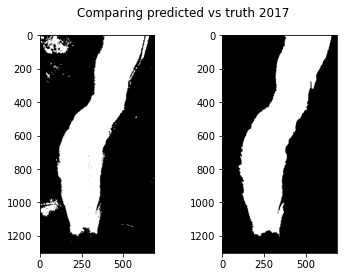

In [11]:
# 2017

GT_PATH = INPUT_DIR + 'gt/binary_gt_2017_0808.npy'
gt_2017 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2017')

ax1.imshow(np.asarray(img_2017), cmap=plt.cm.gray)
ax2.imshow(gt_2017, cmap=plt.cm.gray)

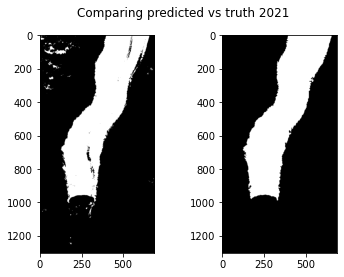

In [12]:
# 2021

GT_PATH = INPUT_DIR + 'gt/binary_gt_2021_2208.npy'
gt_2021 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2021')

ax1.imshow(np.asarray(img_2021), cmap=plt.cm.gray)
ax2.imshow(gt_2021, cmap=plt.cm.gray)

In [13]:
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='x-large')
    
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Ground Truth', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

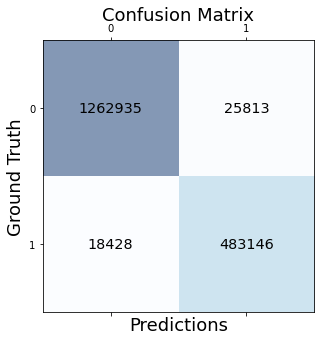

In [14]:
conf_matrix = confusion_matrix(df_test['label'].astype(np.float16), predictions.astype(np.float16))
plot_confusion_matrix(conf_matrix)

### Other metrics

In [15]:
def evaluate_conf(conf_matrix):
    """
    Input: confusion matrix
    =============
    Output: metrics
    """
    
    TP = conf_matrix[1,1]
    FP = conf_matrix[0,1]
    TN = conf_matrix[0,0]
    FN = conf_matrix[1,0]
    
    acc = TP/(FP+TP)
    rec = TP/(FN+TP)
    prec = (TP + TN)/ (TP + FN + TN + FP)
    f1 = 2*prec*rec/ (prec+rec)
    
    print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1)    

In [16]:
evaluate_conf(conf_matrix)

Accuracy:  0.9492827516558309 
Precision:  0.9752888027963684 
Recall:  0.9632596585947437 
F1:  0.9692369088763946


In [17]:
# With sklearn

acc = accuracy_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
rec = recall_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
prec =  precision_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
f1 = f1_score(df_test['label'].astype(np.float16), predictions.astype(np.float16)) 
area_uc = roc_auc_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))

print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1, 
     "\nArea under ROC: ", area_uc)    

Accuracy:  0.9752888027963684 
Precision:  0.9492827516558309 
Recall:  0.9632596585947437 
F1:  0.9562201333355764 
Area under ROC:  0.9716150707875623


### Feature importance

NDSI         0.480762
B02          0.112798
B8A          0.104851
NDWI         0.077311
B12          0.067466
B04          0.054382
entropy      0.043851
meijering    0.027216
B03          0.023713
sobel        0.002838
autolovel    0.002326
hessian      0.002204
sobel_v      0.000167
sobel_h      0.000116
gabor        0.000000
dtype: float64


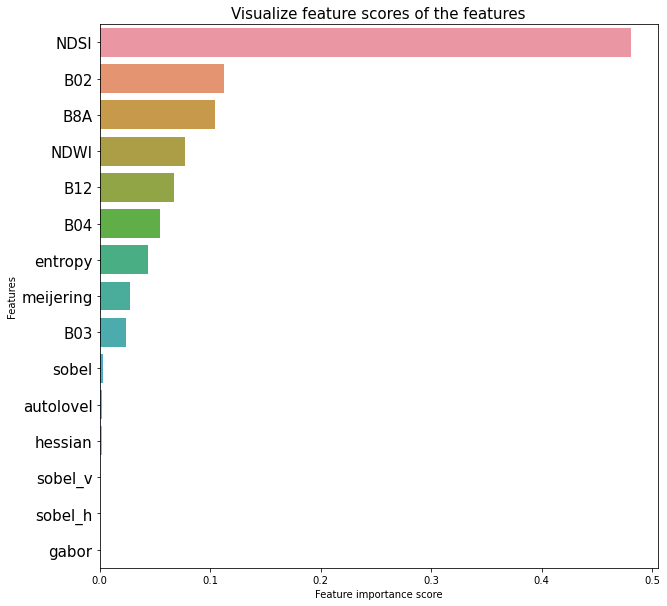

In [18]:
feature_scores = pd.Series(classifier.feature_importances_, index=df_train.iloc[:,:15].columns).sort_values(ascending=False)
print(feature_scores)

# Barplot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features", size=15)
ax.set_yticklabels(feature_scores.index, size=15)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

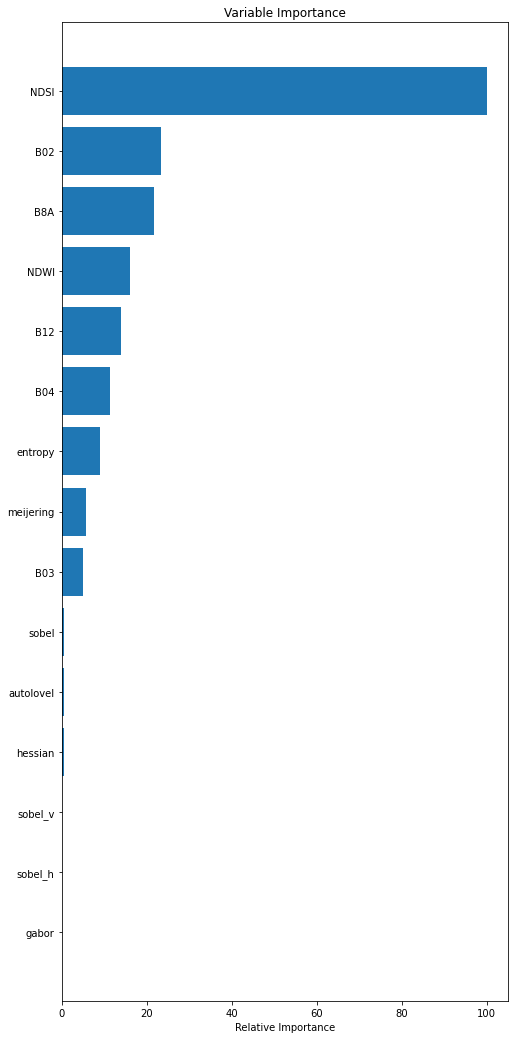

In [21]:
# realtive feature importance

feature_importance = classifier.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df_test.iloc[:, :15].keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 5. Hyperparameter tuning

In [22]:
# List of paramaters to evaluate in the validation set
n_estimators_values = [5,50,250]
max_depth_values = [3,5,7,9]
learning_rate_values = [0.1,1,10]

In [23]:
# Define a validation set (subset of train set)
val_dates = ['2018_2907','2020_0609']
df_val = df_train[df_train['date'].isin(val_dates)]
df_train2 = df_train[~df_train['date'].isin(val_dates)]

In [24]:
# Initialise best_val_accuracy, best_depth and best_n_estimators
best_val_accuracy = -1
best_depth = None
best_n_estimators = None
best_rate = None

for n_estimators_val in n_estimators_values:
    for max_depth_val in max_depth_values:
        for rate in learning_rate_values:
            
            print("eval n_estimators_val: {} max_depth_val: {} rate: {}".format(n_estimators_val, max_depth_val, rate))
            classifier = GradientBoostingClassifier(random_state=10, n_estimators=n_estimators_val, max_depth=max_depth_val, learning_rate=rate)
            classifier.fit(X=df_train2.iloc[:,:15], y=df_train2['label'])
            val_preds = classifier.predict(df_val.iloc[:, :15])
            val_acc = accuracy_score(df_val['label'].astype(np.float16), predictions.astype(np.float16))

            if val_acc > best_val_accuracy:
                best_val_accuracy = val_acc
                best_depth = max_depth_val
                best_n_estimators = n_estimators_val
                best_rate = rate
                print(val_acc)
            
print("Best max depth: " +str(best_depth))
print("Best number estimators: "+str(best_n_estimators))  
print("Best rate: "+str(best_rate))  

eval n_estimators_val: 5 max_depth_val: 3 rate: 0.1
0.9286307155919438
eval n_estimators_val: 5 max_depth_val: 3 rate: 1
eval n_estimators_val: 5 max_depth_val: 3 rate: 10
eval n_estimators_val: 5 max_depth_val: 5 rate: 0.1
eval n_estimators_val: 5 max_depth_val: 5 rate: 1
eval n_estimators_val: 5 max_depth_val: 5 rate: 10
eval n_estimators_val: 5 max_depth_val: 7 rate: 0.1
eval n_estimators_val: 5 max_depth_val: 7 rate: 1
eval n_estimators_val: 5 max_depth_val: 7 rate: 10
eval n_estimators_val: 5 max_depth_val: 9 rate: 0.1
eval n_estimators_val: 5 max_depth_val: 9 rate: 1
eval n_estimators_val: 5 max_depth_val: 9 rate: 10
eval n_estimators_val: 50 max_depth_val: 3 rate: 0.1
eval n_estimators_val: 50 max_depth_val: 3 rate: 1
eval n_estimators_val: 50 max_depth_val: 3 rate: 10
eval n_estimators_val: 50 max_depth_val: 5 rate: 0.1
eval n_estimators_val: 50 max_depth_val: 5 rate: 1
eval n_estimators_val: 50 max_depth_val: 5 rate: 10
eval n_estimators_val: 50 max_depth_val: 7 rate: 0.1
eval

KeyboardInterrupt: 

# 6. Train final GB model & evaluate on test set

In [60]:
import time 
start = time.time()

gb_clf = GradientBoostingClassifier(random_state = 10, n_estimators = 50, max_depth = 3, learning_rate = 0.1)
gb_clf.fit(X = df_train.iloc[:,:15], y = df_train['label'])

end = time.time()
print(end - start) #elapsed time in seconds

17716.089573144913


## Feature importance

NDSI         0.509766
B02          0.112449
B8A          0.100398
NDWI         0.076872
B04          0.052393
B12          0.050787
entropy      0.045815
meijering    0.026031
B03          0.020217
autolevel    0.001783
sobel        0.001723
hessian      0.001713
sobel_v      0.000052
gabor        0.000000
sobel_h      0.000000
dtype: float64


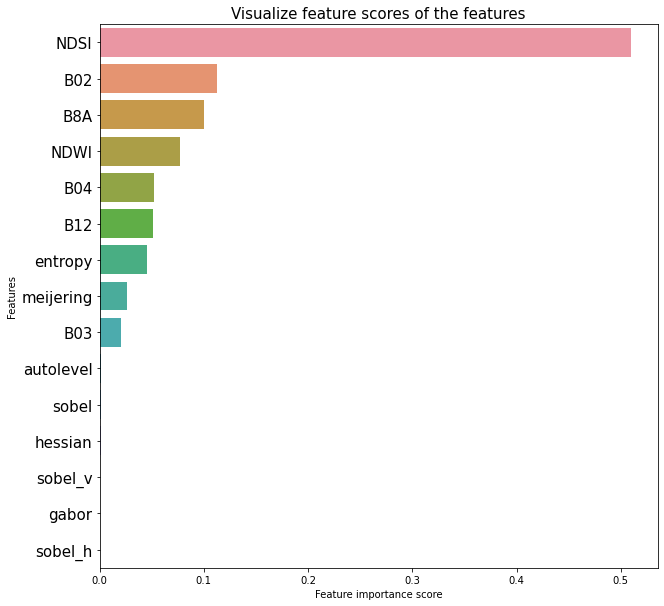

In [61]:
feature_scores = pd.Series(gb_clf.feature_importances_, index=df_train.iloc[:,:15].columns).sort_values(ascending=False)
print(feature_scores)

# Barplot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features", size=15)
ax.set_yticklabels(feature_scores.index, size=15)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

## Performance

In [62]:
from sklearn.metrics import classification_report

predictions = gb_clf.predict(df_test.iloc[:, :15])
print(classification_report(df_test['label'].astype(np.float16), predictions.astype(np.float16)))

              precision    recall  f1-score   support

         0.0       0.98      0.98      0.98   1288748
         1.0       0.95      0.95      0.95    501574

    accuracy                           0.97   1790322
   macro avg       0.97      0.97      0.97   1790322
weighted avg       0.97      0.97      0.97   1790322



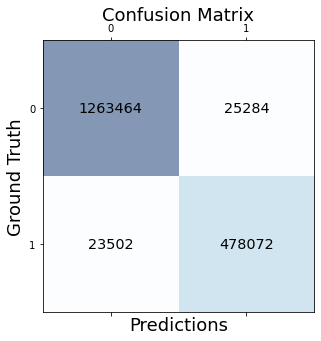

In [63]:
conf_matrix = confusion_matrix(df_test['label'].astype(np.float16), predictions.astype(np.float16))
plot_confusion_matrix(conf_matrix)

In [64]:
# With sklearn

acc = accuracy_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
rec = recall_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
prec =  precision_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
f1 = f1_score(df_test['label'].astype(np.float16), predictions.astype(np.float16)) 
area_uc = roc_auc_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))

print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1, 
     "\nArea under ROC: ", area_uc) 

Accuracy:  0.9727501533243741 
Precision:  0.9497691494687657 
Recall:  0.9531435042486254 
F1:  0.9514533350581633 
Area under ROC:  0.9667622315663759


## Predict on 2017 and 2021 

In [65]:
nb_pixels = gt_binary.shape[0]*gt_binary.shape[1] # number of pixels in an image

img_2017 = predictions[0:nb_pixels].reshape((1303, 687)).astype(np.float32)
img_2021 = predictions[nb_pixels:].reshape((1303, 687)).astype(np.float32)

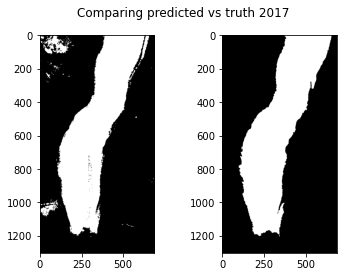

In [66]:
# 2017

GT_PATH = INPUT_DIR + 'gt/binary_gt_2017_0808.npy'
gt_2017 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2017')

ax1.imshow(np.asarray(img_2017), cmap=plt.cm.gray)
ax2.imshow(gt_2017, cmap=plt.cm.gray)

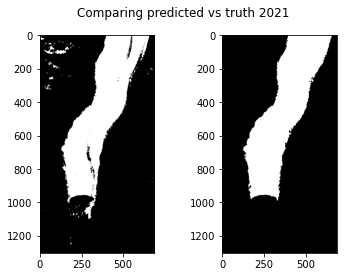

In [67]:
# 2021

GT_PATH = INPUT_DIR + 'gt/binary_gt_2021_2208.npy'
gt_2021 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2021')

ax1.imshow(np.asarray(img_2021), cmap=plt.cm.gray)
ax2.imshow(gt_2021, cmap=plt.cm.gray)

## Surface computation 

In [68]:
# Save predictions
np.save('img_2017_GB_McB.npy', img_2017) 
np.save('img_2021_GB_McB.npy', img_2021)

In [69]:
glacier_2017 = img_2017[img_2017==1].sum()
glacier_2021 = img_2021[img_2021==1].sum()
diff_glacier = glacier_2017 - glacier_2021

print('There are ', diff_glacier, 'glacier pixels of difference from 2017 to 2021')

There are  71116.0 glacier pixels of difference from 2017 to 2021


In [71]:
lost_surface = (23.67*diff_glacier)/(1303*687)
print('McBride lost', lost_surface, 'km^2 between 2017 and 2021')

McBride lost 1.8804614142037022 km^2 between 2017 and 2021


# Train for max depth equal 5

In [44]:
import time 
start = time.time()

gb_clf = GradientBoostingClassifier(random_state = 10, n_estimators = 50, max_depth = 5, learning_rate = 0.1)
gb_clf.fit(X = df_train.iloc[:,:15], y = df_train['label'])

end = time.time()
print(end - start) #elapsed time in seconds

10832.784548997879


NDSI         0.469507
B8A          0.106600
B02          0.106158
B12          0.085184
NDWI         0.063173
B04          0.052855
entropy      0.046146
meijering    0.032087
B03          0.027607
sobel        0.004200
hessian      0.003054
autolevel    0.002704
sobel_h      0.000434
sobel_v      0.000291
gabor        0.000000
dtype: float64


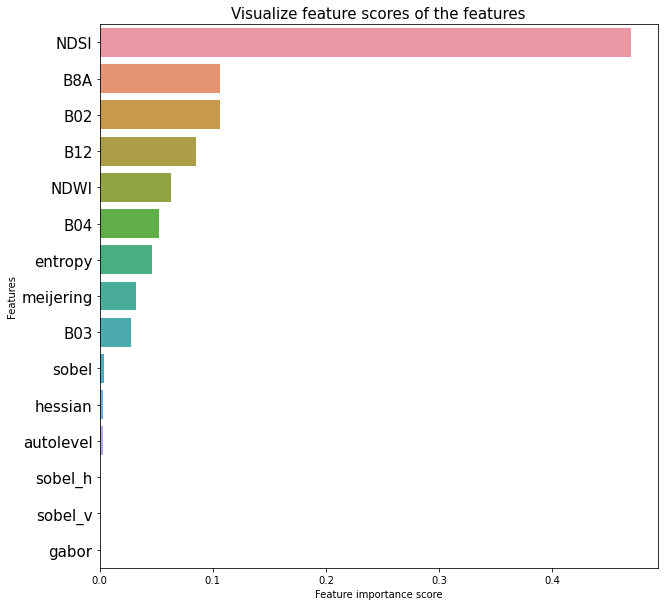

In [45]:
## Feature importance
feature_scores = pd.Series(gb_clf.feature_importances_, index=df_train.iloc[:,:15].columns).sort_values(ascending=False)
print(feature_scores)

# Barplot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features", size=15)
ax.set_yticklabels(feature_scores.index, size=15)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [46]:
## Performance
from sklearn.metrics import classification_report

predictions = gb_clf.predict(df_test.iloc[:, :15])
print(classification_report(df_test['label'].astype(np.float16), predictions.astype(np.float16)))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98   1288748
         1.0       0.95      0.97      0.96    501574

    accuracy                           0.98   1790322
   macro avg       0.97      0.98      0.97   1790322
weighted avg       0.98      0.98      0.98   1790322



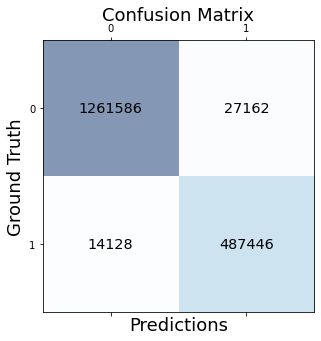

In [47]:
conf_matrix = confusion_matrix(df_test['label'].astype(np.float16), predictions.astype(np.float16))
plot_confusion_matrix(conf_matrix)

In [48]:
# With sklearn

acc = accuracy_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
rec = recall_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
prec =  precision_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
f1 = f1_score(df_test['label'].astype(np.float16), predictions.astype(np.float16)) 
area_uc = roc_auc_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))

print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1, 
     "\nArea under ROC: ", area_uc) 

Accuracy:  0.9769371096372608 
Precision:  0.9472180766719522 
Recall:  0.9718326707524713 
F1:  0.9593675148743039 
Area under ROC:  0.9753782006904786


In [49]:
## Prediction

nb_pixels = gt_binary.shape[0]*gt_binary.shape[1] # number of pixels in an image

img_2017 = predictions[0:nb_pixels].reshape((1303, 687)).astype(np.float32)
img_2021 = predictions[nb_pixels:].reshape((1303, 687)).astype(np.float32)

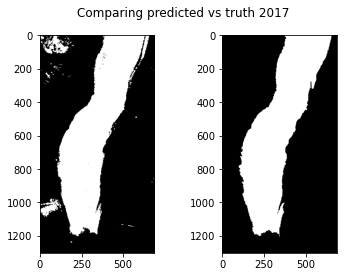

In [50]:
# 2017

GT_PATH = INPUT_DIR + 'gt/binary_gt_2017_0808.npy'
gt_2017 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2017')

ax1.imshow(np.asarray(img_2017), cmap=plt.cm.gray)
ax2.imshow(gt_2017, cmap=plt.cm.gray)

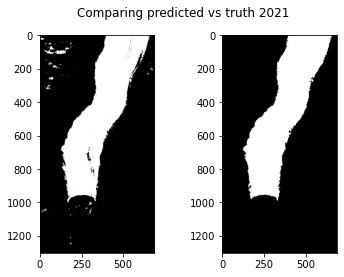

In [51]:
# 2021

GT_PATH = INPUT_DIR + 'gt/binary_gt_2021_2208.npy'
gt_2021 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2021')

ax1.imshow(np.asarray(img_2021), cmap=plt.cm.gray)
ax2.imshow(gt_2021, cmap=plt.cm.gray)

# N_estimators = 100

In [52]:
import time 
start = time.time()

gb_clf = GradientBoostingClassifier(random_state = 10, n_estimators = 100, max_depth = 5, learning_rate = 0.1)
gb_clf.fit(X = df_train.iloc[:,:15], y = df_train['label'])

end = time.time()
print(end - start) #elapsed time in seconds

23223.844863176346


NDSI         4.408268e-01
B8A          1.063260e-01
B12          1.049513e-01
B02          1.040516e-01
NDWI         6.373606e-02
B04          5.963752e-02
entropy      4.347458e-02
B03          3.352388e-02
meijering    3.197890e-02
sobel        4.456337e-03
hessian      2.976486e-03
autolevel    2.833899e-03
sobel_h      8.564303e-04
sobel_v      3.694696e-04
gabor        8.328166e-07
dtype: float64


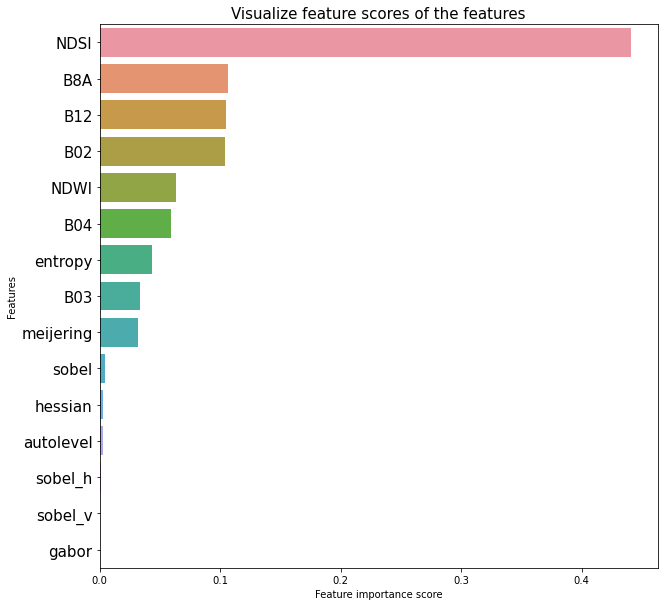

In [53]:
## Feature importance
feature_scores = pd.Series(gb_clf.feature_importances_, index=df_train.iloc[:,:15].columns).sort_values(ascending=False)
print(feature_scores)

# Barplot
f, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features", size=15)
ax.set_yticklabels(feature_scores.index, size=15)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()

In [54]:
## Performance
from sklearn.metrics import classification_report

predictions = gb_clf.predict(df_test.iloc[:, :15])
print(classification_report(df_test['label'].astype(np.float16), predictions.astype(np.float16)))

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98   1288748
         1.0       0.94      0.97      0.96    501574

    accuracy                           0.98   1790322
   macro avg       0.97      0.98      0.97   1790322
weighted avg       0.98      0.98      0.98   1790322



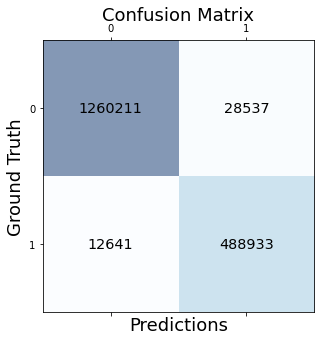

In [55]:
conf_matrix = confusion_matrix(df_test['label'].astype(np.float16), predictions.astype(np.float16))
plot_confusion_matrix(conf_matrix)

In [56]:
# With sklearn

acc = accuracy_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
rec = recall_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
prec =  precision_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))
f1 = f1_score(df_test['label'].astype(np.float16), predictions.astype(np.float16)) 
area_uc = roc_auc_score(df_test['label'].astype(np.float16), predictions.astype(np.float16))

print("Accuracy: ", acc, 
     "\nPrecision: ", prec, 
     "\nRecall: ", rec,
     "\nF1: ", f1, 
     "\nArea under ROC: ", area_uc) 

Accuracy:  0.9769996682161086 
Precision:  0.9448528417106306 
Recall:  0.9747973379800389 
F1:  0.9595915387363059 
Area under ROC:  0.976327070818771


In [57]:
## Prediction

nb_pixels = gt_binary.shape[0]*gt_binary.shape[1] # number of pixels in an image

img_2017 = predictions[0:nb_pixels].reshape((1303, 687)).astype(np.float32)
img_2021 = predictions[nb_pixels:].reshape((1303, 687)).astype(np.float32)

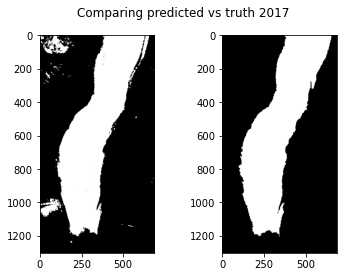

In [58]:
# 2017

GT_PATH = INPUT_DIR + 'gt/binary_gt_2017_0808.npy'
gt_2017 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2017')

ax1.imshow(np.asarray(img_2017), cmap=plt.cm.gray)
ax2.imshow(gt_2017, cmap=plt.cm.gray)

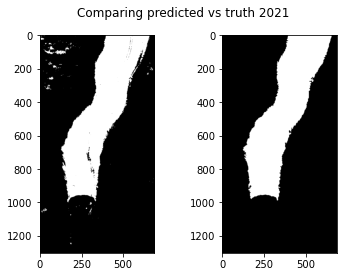

In [59]:
# 2021

GT_PATH = INPUT_DIR + 'gt/binary_gt_2021_2208.npy'
gt_2021 = np.load(GT_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparing predicted vs truth 2021')

ax1.imshow(np.asarray(img_2021), cmap=plt.cm.gray)
ax2.imshow(gt_2021, cmap=plt.cm.gray)

# 7. Compute ice melting & view results